In [14]:
# 妈妈杯问题B：甲骨文智能识别中原始拓片单字自动分割与识别研究 求解思路

In [9]:
# 针对问题一，我们对附件一的甲骨文图像数据进行数据预处理
# 包括但不限于：
# 尺寸调整：将图像调整为模型要求的输入尺寸，通常是正方形或者某个固定的长宽比。
# 归一化：将图像的像素值缩放到固定范围内，例如0,1或−1,1，以便于模型的训练。
# 数据增强：通过随机旋转、裁剪、翻转、变换亮度和对比度等方式来增加训练数据的多样性，从而提高模型的泛化能力。
# 图像增强：对图像进行增强操作，如调整亮度、对比度、锐度、颜色等，以增强图像的特征。

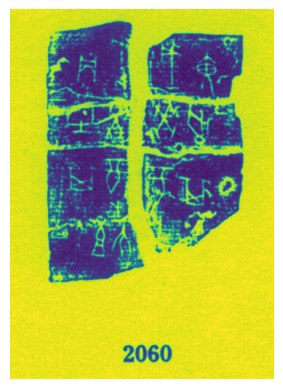

In [11]:
import cv2
import numpy as np
import torch
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# 读取图像
image_path1 = r'cup_data\1_Pre_test\h02060.jpg'
image_path2 = r'cup_data\1_Pre_test\w01637.jpg'
image_path3 = r'cup_data\1_Pre_test\w01870.jpg'
image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
image3 = cv2.imread(image_path3)

# 定义目标尺寸
target_size = (416, 416)  # YOLOv5 推荐的尺寸

# 调整大小
resized_image1 = cv2.resize(image1, target_size)
resized_image2 = cv2.resize(image2, target_size)
resized_image3 = cv2.resize(image3, target_size)

# 将图像归一化为 [0, 1]
normalized_image = []
normalized_image.append(resized_image1.astype(np.float32) / 255.0)
normalized_image.append(resized_image2.astype(np.float32) / 255.0)
normalized_image.append(resized_image3.astype(np.float32) / 255.0)
# 如果需要旋转，可以在这里进行旋转操作

# 将图像转换为 PyTorch 的 Tensor 格式，并添加批次维度
tensor_image = torch.tensor(normalized_image[0]).permute(2, 0, 1).unsqueeze(0)

# 现在 tensor_image 就是你所需的输入数据，准备用于 YOLOv5 模型
plt.imshow(image1)
plt.axis('off')
plt.show()

In [ ]:
# 以上我们在对图像数据进行归一化等预处理
# 在微调yolov5前，我们需要将labels数据处理成yolo能接受的数据

In [4]:
# 首先我们将附件2给出的甲骨文框坐标批量归一化，代码如下：
import os

from PIL import Image
from tqdm import tqdm

def normalize_bbox(width, height, x1, y1, w, h):
    """
    Normalize bounding box coordinates.
    Returns:
        tuple: 归一化后的矩形框坐标 (xmin, ymin, xmax, ymax)。
    """
    xmin = round(x1 / width, 4)
    ymin = round(y1 / height, 4)
    xmax = round(w / width, 4)
    ymax = round(h / height, 4)

    return [xmin, ymin, xmax, ymax]
path = "cup_data/train_yolo5/labels2/train"
image_list = os.listdir(path)

for il in tqdm(image_list):
    txt_path = os.path.join(path, il)
    # 打开txt文件
    with open(txt_path, 'r') as file:
        # 逐行读取文件内容
        rus = []
        for line in file:
            # 移除行末的换行符，并将每行内容按空格分割成列表
            line_data = line.strip().split()
            # 获取每行的后四个数字（假设每行都至少有五个数字）
            # last_four_numbers = line_data[1:]
            rus.append(line_data)
            # 打印后四个数字
    # 示例用法
    # 打开图像文件
    image_path = "cup_data/train_yolo5/images/train/" + il[:-4] + ".jpg"
    image = Image.open(image_path)

    # 获取图像的长和宽
    width, height = image.size
    tem = []
    for rs in range(len(rus)):
        x1 = float(rus[rs][1])+float(rus[rs][3]) / 2
        y1 = float(rus[rs][2])+float(rus[rs][4]) / 2
        w = abs(float(rus[rs][1])-float(rus[rs][3]))
        h = abs(float(rus[rs][2])-float(rus[rs][4]))

        # 归一化矩形框坐标
        normalized_bbox = normalize_bbox(width, height, x1, y1, w, h)
        normalized_bbox = [int(0)] + normalized_bbox
        tem = tem + normalized_bbox
    # 将变量写入txt文件，每五个一行，用空格分隔
    write_path = os.path.join("cup_data/train_yolo5/labels/train", f"{il}")
    with open(write_path, 'w') as file:
        for i in range(0, len(tem), 5):
            line = ' '.join(map(str, tem[i:i + 5])) + '\n'
            file.write(line)
# 注意，这里我将附件二的labels文件与图像文件分开存储，最大可能的不改动yolo官方提供的代码

100%|████████████████████████████████████████████████████████████████████████████| 6082/6082 [00:02<00:00, 2795.63it/s]


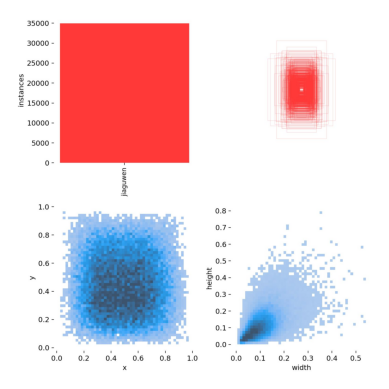

In [1]:
# 我们对归一化后的labels文件拟合其分布，查看甲骨文图像数据相关信息（标签分布、甲骨文在图像中坐标点x、y分布
# 甲骨文出现在图片中的大小（宽、高）分布）的分布情况，结果在下面两张图中展示
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 读取图像文件
image = mpimg.imread('jupyter_need/labels.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

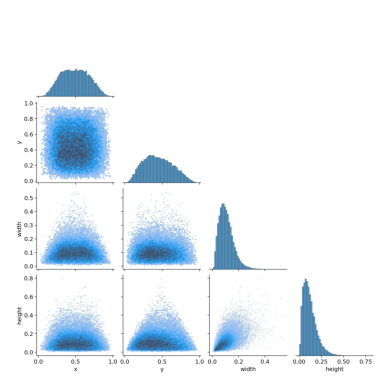

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 读取图像文件
image = mpimg.imread('jupyter_need/labels_correlogram.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [24]:
# 针对问题二，基于yolov5模型，利用附件2中的数据对模型进行微调，使其具备单字检测分割的能力。
# 我们将部分分割结果可视化，验证模型分割能力。

In [11]:
# 针对问题三，利用第二问得到的检测分割模型，在附件三测试集上对测试数据进行检测分割，并保存结果到附件Test_results.xlsx

In [12]:
# 针对问题四，附件四给出部分甲骨文图像及其对应的简体中文，我们建立inception_v3分类模型，通过训练数据对模型进行微调。
# 将得到的在甲骨文文字识别任务上微调后的inception_v3模型对测试集数据进行文字识别。
# 将识别结果保存，写入论文